In [5]:
%pip install nltk wordcloud xgboost lightgbm catboost 
%pip uninstall leia-br -y
%pip install leia-br

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


  Using cached leia_br-0.0.1-py2.py3-none-any.whl.metadata (2.9 kB)
Using cached leia_br-0.0.1-py2.py3-none-any.whl (130 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Text Processing Libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from nltk import ngrams

# Sentiment Analysis
from LeIA import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, 
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mumu1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mumu1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
from IPython.core.display import HTML
HTML('''<style>
div.output_area {
    max-height: none !important;
}
</style>''')

# 출력 제한 완전히 제거
get_ipython().run_line_magic('config', "InlineBackend.print_figure_kwargs = {'bbox_inches': None}") 

In [8]:
from RFM import df_order_reviews, df_product_category_name_translation, df_products, merge_coi

# Merging

In [9]:
# 1) 전체 분석 review_comment_message, product_category_name, order_id
# 2) 이탈고객 vs 잠재우수 고객

df_reviews = df_order_reviews[['order_id', 'review_comment_message']]

# merge_coi + df_products = NLP
NLP = merge_coi.merge(
    df_products[['product_id', 'product_category_name']],  
    on='product_id',
    how='inner'
)

# NLP + df_reviews = NLP
NLP = NLP.merge(
    df_reviews[['order_id', 'review_comment_message']], 
    on='order_id',
    how='inner'
)


# Data cleaning

In [10]:
# 데이터 선택 및 기본 정제
clean_NLP = NLP[['order_id', 'review_comment_message', 'product_category_name']]

# 결측치 제거
clean_NLP = clean_NLP.dropna(subset=['product_category_name', 'review_comment_message'])

# 중복 제거
clean_NLP = clean_NLP.drop_duplicates(subset=['review_comment_message']).reset_index(drop=True)

clean_NLP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33495 entries, 0 to 33494
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   order_id                33495 non-null  object
 1   review_comment_message  33495 non-null  object
 2   product_category_name   33495 non-null  object
dtypes: object(3)
memory usage: 785.2+ KB


# text preprocessing

In [11]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode

# 1. 불용어 설정 
STOP_WORDS = set(stopwords.words('portuguese')) | {
    'dia', 'bom', 'fiz', 'td', 'q', 'mim', 'bem', 'ainda', 'tudo',
    'ra', 'sa', 'ter', 'sido', 'veio', 'vai', 'fazer', 'assim',
    'ate', 'pra', 'pro', 'pela', 'pelo', 'tbm', 'vc', 'eh'
}

# 2. 전처리 함수 
def simple_clean(text):
    if not isinstance(text, str): return ""
    
    # 소문자 변환 -> 유니코드 정규화(accent 제거) -> 알파벳 제외한 모든 문자(숫자, 특수문자) 공백 치환
    text = re.sub(r'[^a-z\s]', ' ', unidecode(text.lower()))
    
    # 불용어 제거 및 2글자 이상만 남기기
    return " ".join([w for w in text.split() if w not in STOP_WORDS and len(w) > 1])

# 3. 데이터프레임 적용(결측치만 제거)
clean_NLP = clean_NLP.dropna(subset=['review_comment_message']).copy()

# 텍스트 정제 적용
clean_NLP['review_comment_message_clean'] = clean_NLP['review_comment_message'].apply(simple_clean)

# 빈 결과 제거 (전처리 후 내용이 다 사라진 경우)
clean_NLP = clean_NLP[clean_NLP['review_comment_message_clean'] != ""]

# 토큰화 컬럼 생성
clean_NLP['review_comment_message_tokens'] = clean_NLP['review_comment_message_clean'].str.split()

# 결과 확인
print(clean_NLP[['review_comment_message', 'review_comment_message_clean', 'review_comment_message_tokens']].head())

                           review_comment_message  \
0  O baratheon Ã¨ esxelente Amo adoro o baratheon   
1                               Loja responsÃ¡vel   
2                       chegou antes do prometido   
3        Ã³timo, entregou antes da data prevista.   
4            Td certo.Produto e prazo de entrega.   

              review_comment_message_clean  \
0  baratheon esxelente amo adoro baratheon   
1                        loja responsa vel   
2                   chegou antes prometido   
3        timo entregou antes data prevista   
4              certo produto prazo entrega   

                   review_comment_message_tokens  
0  [baratheon, esxelente, amo, adoro, baratheon]  
1                          [loja, responsa, vel]  
2                     [chegou, antes, prometido]  
3        [timo, entregou, antes, data, prevista]  
4               [certo, produto, prazo, entrega]  



# `SentimentIntensityAnalyzer` in LeIA

In [ ]:
# Initialize the Sentiment Analyzer once
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(df, column_name='review_comment_message_clean'):
    # Vectorized function to get sentiment classification
    def get_sentiment_classification(text):
        scores = analyzer.polarity_scores(text)
        if scores['compound'] >= 0.05:
            return 'Positive'
        elif scores['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    
    # Apply sentiment analysis using map for faster iteration
    df[f'{column_name}_sentiment'] = df[column_name].map(get_sentiment_classification)
    return df

# Classify sentiment in 'clean_NLP' based on the 'review_comment_message_clean' column
clean_NLP = classify_sentiment(clean_NLP, 'review_comment_message_clean')

# Display the sentiment results
# clean_NLP[['review_comment_message_clean', 'review_comment_message_clean_sentiment']].head(25)

clean_NLP.info()

# 피케이 파일로 저장
clean_NLP.to_parquet('clean_NLP_data.parquet', engine='pyarrow', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 33314 entries, 0 to 33494
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   order_id                                33314 non-null  object
 1   review_comment_message                  33314 non-null  object
 2   product_category_name                   33314 non-null  object
 3   review_comment_message_clean            33314 non-null  object
 4   review_comment_message_tokens           33314 non-null  object
 5   review_comment_message_clean_sentiment  33314 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


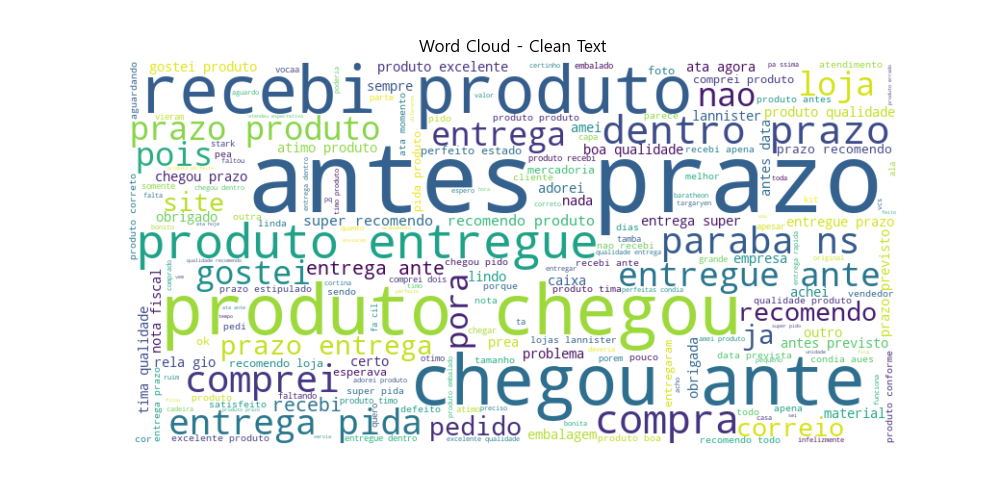

In [13]:
# Concatenate all non-null texts from the 'cleaned_text' column into a single string
text_combined = " ".join(clean_NLP['review_comment_message_clean'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Clean Text")
plt.axis("off")  # Remove the axes
plt.show()

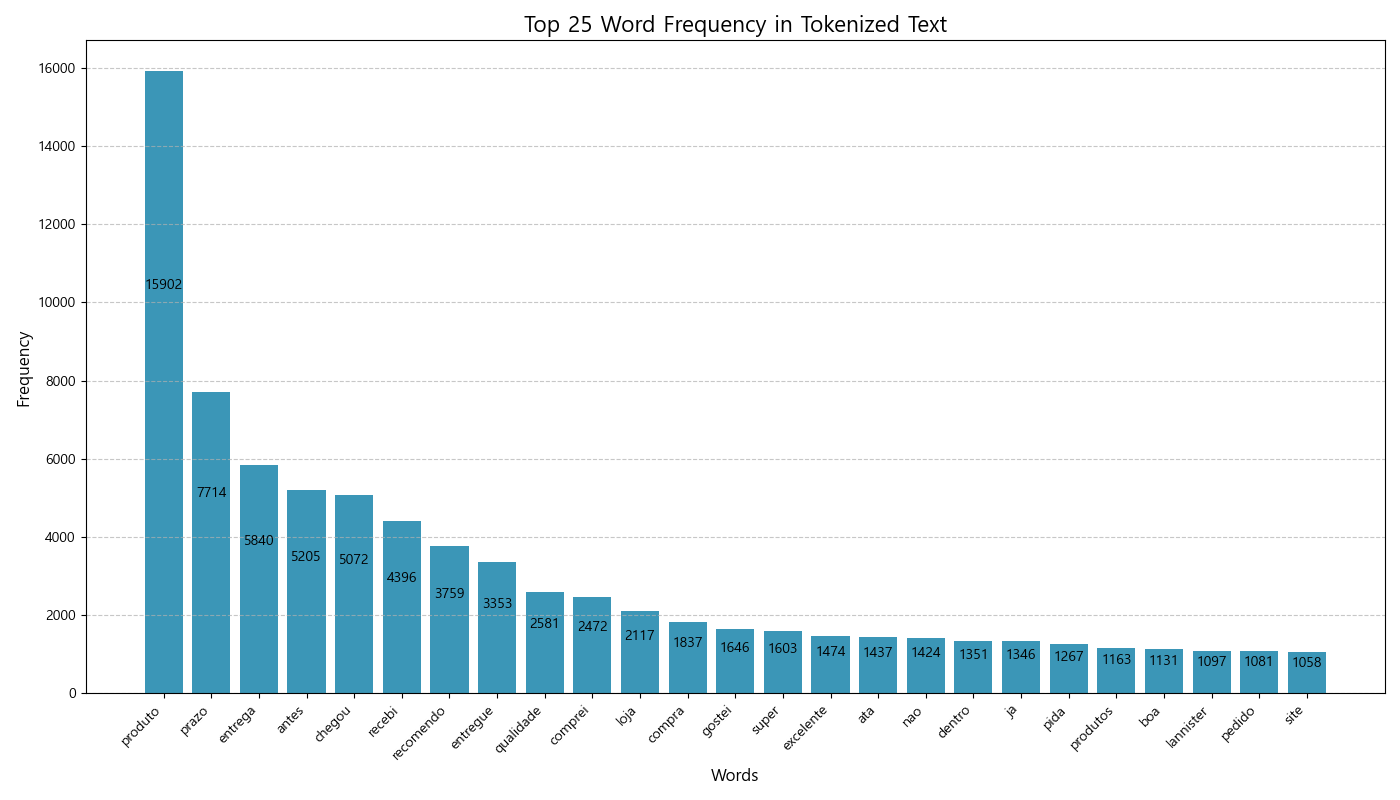

In [14]:
#EDA
# Function to get top N tokens or n-grams
def get_top_tokens(clean_NLP, token_column='review_comment_message_tokens', top_n=50):
    all_tokens = [token for tokens in clean_NLP[token_column] for token in tokens]
    token_counts = Counter(all_tokens)
    return token_counts.most_common(top_n)

# Function to create a DataFrame from frequency counts
def create_frequency_df(counter, columns=['Word', 'Frequency']):
    return pd.DataFrame(counter.items(), columns=columns)

# General plotting function for bar charts
def plot_top_frequencies(clean_NLP, title, xlabel, column_name):
    plt.figure(figsize=(14, 8))
    bars = plt.bar(clean_NLP[column_name], clean_NLP['Frequency'], color='#3b96b7')
    
    # Add labels
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() - max(5, bar.get_height() * 0.35), 
                 f'{int(bar.get_height())}', ha='center', color='black', fontsize=10)

    # Customize and show plot
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Get top tokens and plot
top_50_tokens = get_top_tokens(clean_NLP, 'review_comment_message_tokens', 50)
top_50_tokens_df = create_frequency_df(dict(top_50_tokens))
plot_top_frequencies(top_50_tokens_df.head(25), 'Top 25 Word Frequency in Tokenized Text', 'Words', 'Word')

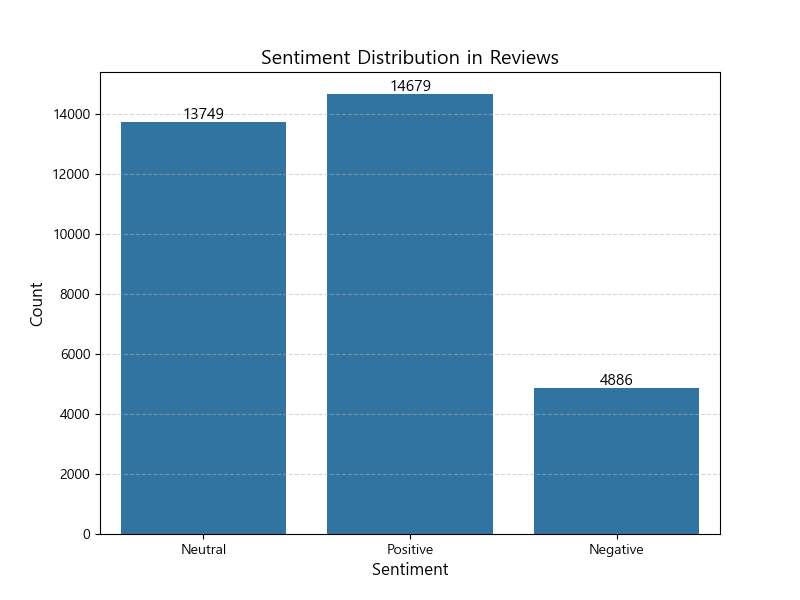

In [15]:
# Plot the sentiment count
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="review_comment_message_clean_sentiment", data=clean_NLP)

# Add labels and title
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Distribution in Reviews", fontsize=14)

# Display value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Reduce gridline visibility for a cleaner look
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.5)

plt.show()

In [16]:
clean_NLP[['review_comment_message_clean', 'review_comment_message_clean_sentiment']].head()

,review_comment_message_clean,review_comment_message_clean_sentiment
0,baratheon esxelente amo adoro baratheon,Neutral
1,loja responsa vel,Neutral
2,chegou antes prometido,Positive
3,timo entregou antes data prevista,Neutral
4,certo produto prazo entrega,Positive


# Data Preprocessing

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

X = clean_NLP['review_comment_message']
y = clean_NLP['review_comment_message_clean_sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

for index, label in enumerate(label_encoder.classes_):
    print(f"숫자 {index} = {label}")

print(f"Unique values ​​in y_train_encoded after encoding: {y_train_encoded}")

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) # Test셋은 fit 하지 않고 transform만!

숫자 0 = Negative
숫자 1 = Neutral
숫자 2 = Positive
Unique values ​​in y_train_encoded after encoding: [1 2 2 ... 2 1 2]


# Machine Learning

In [ ]:
%%time
import pandas as pd
from sklearn.naive_bayes import MultinomialNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# 1. 모델
models = {
    "MultinomialNB": MultinomialNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(random_state=50, max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=45),
    "XGBClassifier": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LGBMClassifier": LGBMClassifier(verbosity=-1, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(kernel='linear', random_state=42, probability=True),
    "CatBoostClassifier": CatBoostClassifier(verbose=0, random_state=42)
}

results = []

# 2. 모델 학습 및 평가
for name, model in models.items():
    try:
        model.fit(X_train_tfidf, y_train_encoded)
        
        # 예측
        train_pred = model.predict(X_train_tfidf)
        test_pred = model.predict(X_test_tfidf)
        
        # 정확도 계산
        train_accuracy = accuracy_score(y_train_encoded, train_pred)
        test_accuracy = accuracy_score(y_test_encoded, test_pred)
        
        results.append({
            "Model": name, 
            "Training Accuracy": train_accuracy, 
            "Testing Accuracy": test_accuracy
        })
        print(f"[완료] {name:25s} | Test Acc: {test_accuracy:.4f}")
        
    except Exception as e:
        print(f"[에러] {name}: {e}")

# 3. 결과 DataFrame 생성 및 정렬 (Test 정확도 높은 순)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Testing Accuracy", ascending=False)

# 결과 출력
print("\n=== 최종 결과 (정확도 순) ===")
display(results_df)

[완료] MultinomialNB             | Test Acc: 0.8201
[완료] DecisionTreeClassifier    | Test Acc: 0.8991
[완료] RandomForestClassifier    | Test Acc: 0.8994
[완료] LogisticRegression        | Test Acc: 0.9308
[완료] AdaBoostClassifier        | Test Acc: 0.6587
[완료] XGBClassifier             | Test Acc: 0.9214
[완료] LGBMClassifier            | Test Acc: 0.9373
[완료] KNeighborsClassifier      | Test Acc: 0.6146
[완료] GradientBoostingClassifier | Test Acc: 0.8687


# 결과 테스트

In [ ]:
# 1. 1등 모델
best_model = models["SVC"]

# 2. 테스트
new_reviews = [
    "Chegou no dia seguinte ao pedido e fiquei surpreso. A entrega foi rápida e gostei muito do produto. Super recomendo!",
    # "주문한 다음 날 바로 도착해서 깜짝 놀랐어요. 배송도 빠르고 제품도 너무 마음에 들어서 강력 추천합니다!" 긍정 배송추천
    "É muito mais bonito pessoalmente do que na foto. O acabamento é limpo e a qualidade superou minhas expectativas. Estou muito satisfeito.",
    # "사진보다 실물이 훨씬 예쁘네요. 마감 처리도 깔끔하고 퀄리티가 기대 이상이라 아주 만족스럽습니다." 긍정 품질만족
    "Chegou com 3 dias de atraso em relação ao prazo. Eu precisava com urgência, não consegui contato e fiquei frustrado.",
    # "배송 예정일보다 3일이나 늦게 도착했습니다. 급하게 필요했는데 연락도 안 되고 답답했네요." 부정 배송지연
    "A caixa chegou toda amassada e o produto tem riscos. A embalagem foi uma decepção. Quero devolver.",
    # "박스가 다 찌그러져서 왔고 제품에도 스크래치가 있네요. 포장 상태가 너무 실망스럽습니다. 반품하고 싶어요." 부정 상품불량
    "O custo-benefício é excelente, mas a entrega foi um pouco lenta. Se não tiver pressa, vale a pena comprar."
    # "가격 대비 성능은 훌륭한 편인데, 배송이 조금 느린 게 아쉽네요. 급하지 않다면 살만합니다. 중립 복합 가성비
]

# 3. 데이터 변환 (Text -> Number)
# 학습 때 쓴 vectorizer를 그대로 사용해서 transform
new_reviews_tfidf = vectorizer.transform(new_reviews)

# 4. 예측 (Predict)
# 결과값: 0 또는 1 
pred_labels_encoded = best_model.predict(new_reviews_tfidf)

# 5. 확률 계산 (Probability)
# 결과값: [[부정확률, 긍정확률], ...]
pred_probs = best_model.predict_proba(new_reviews_tfidf)

# 6. 숫자 -> 글자 변환 (Decoder)
# 0, 1 -> "부정", "긍정"으로 다시 번역
pred_labels_text = label_encoder.inverse_transform(pred_labels_encoded)

# 7. 결과 출력
print(f"=== {best_model.__class__.__name__} 예측 결과 ===\n")

for i, review in enumerate(new_reviews):
    sentiment = pred_labels_text[i]          # 예측된 감성 (긍정/부정)
    probability = pred_probs[i].max() * 100  # 가장 높은 확률값 (확신도)
    
    print(f"📝 리뷰: {review}")
    print(f"🤖 예측: {sentiment} ({probability:.2f}% 확신)\n")

=== SVC 예측 결과 ===

📝 리뷰: Chegou no dia seguinte ao pedido e fiquei surpreso. A entrega foi rápida e gostei muito do produto. Super recomendo!
🤖 예측: Positive (100.00% 확신)

📝 리뷰: É muito mais bonito pessoalmente do que na foto. O acabamento é limpo e a qualidade superou minhas expectativas. Estou muito satisfeito.
🤖 예측: Positive (100.00% 확신)

📝 리뷰: Chegou com 3 dias de atraso em relação ao prazo. Eu precisava com urgência, não consegui contato e fiquei frustrado.
🤖 예측: Negative (96.83% 확신)

📝 리뷰: A caixa chegou toda amassada e o produto tem riscos. A embalagem foi uma decepção. Quero devolver.
🤖 예측: Negative (88.77% 확신)

📝 리뷰: O custo-benefício é excelente, mas a entrega foi um pouco lenta. Se não tiver pressa, vale a pena comprar.
🤖 예측: Positive (96.15% 확신)



koreanize_matplotlib 설치 중...


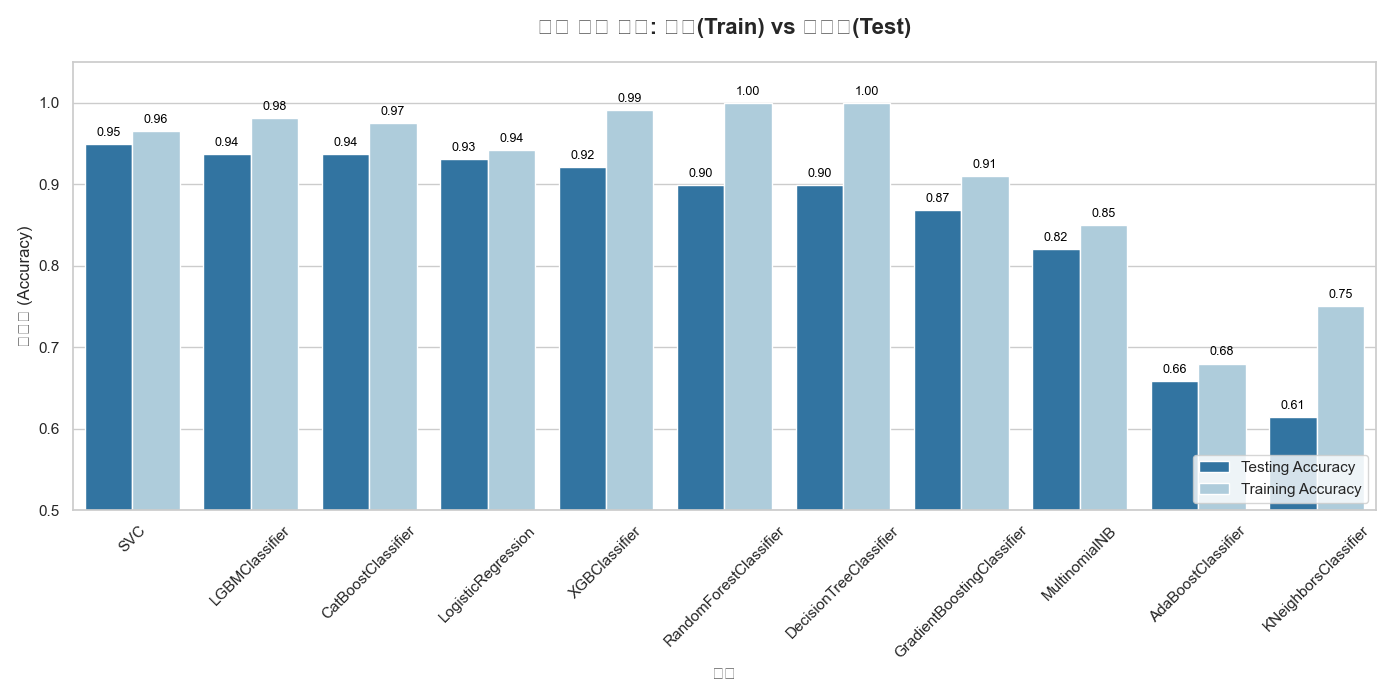

C:\Users\mumu1\AppData\Local\Temp\ipykernel_8932\2296238454.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


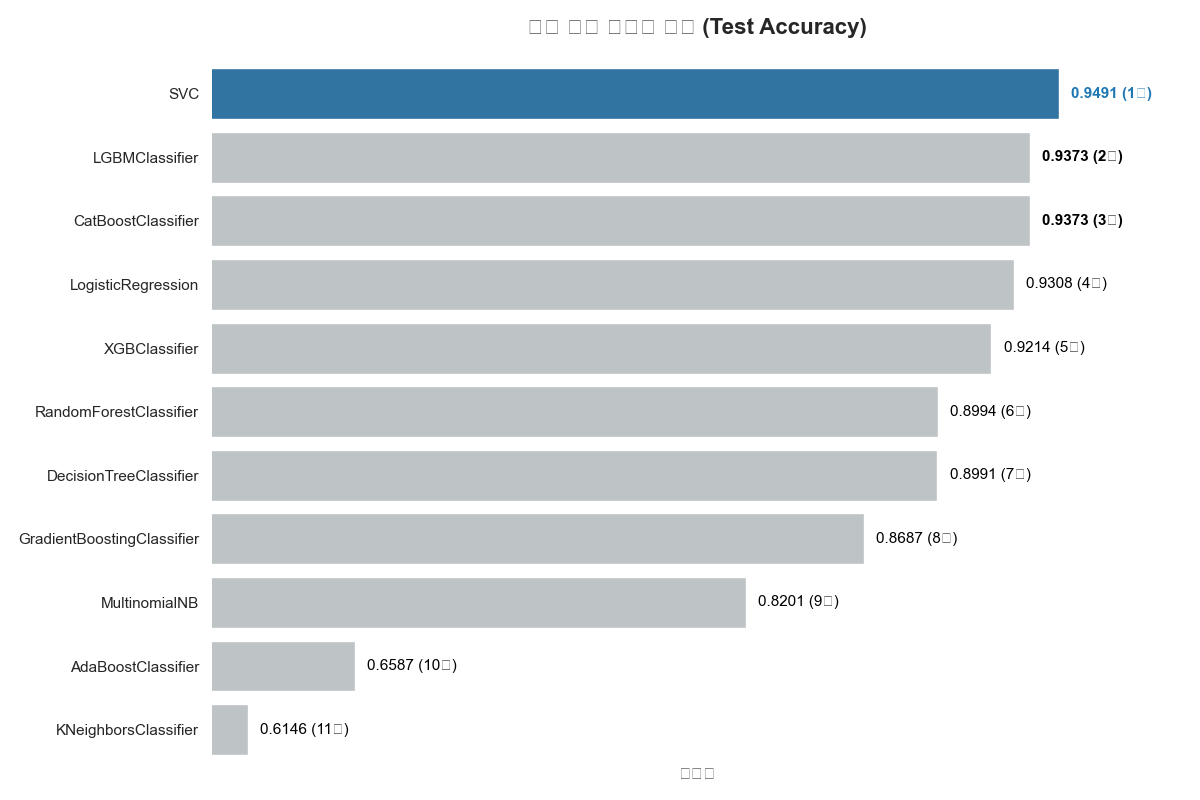

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import subprocess

# 1. 한글 폰트 설정 
try:
    import koreanize_matplotlib
except ImportError:
    print("koreanize_matplotlib 설치 중...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "koreanize-matplotlib"])
    import koreanize_matplotlib

# 2. 데이터 준비 (이미지의 결과값 그대로 입력)
# 사용자의 실행 결과를 바탕으로 DataFrame을 직접 생성하여 바로 실행 가능하게 만듭니다.
data = {
    "Model": [
        "SVC", "LGBMClassifier", "CatBoostClassifier", "LogisticRegression",
        "XGBClassifier", "RandomForestClassifier", "DecisionTreeClassifier",
        "GradientBoostingClassifier", "MultinomialNB", "AdaBoostClassifier",
        "KNeighborsClassifier"
    ],
    # Test Accuracy (이미지 기준)
    "Testing Accuracy": [
        0.9491, 0.9373, 0.9373, 0.9308, 
        0.9214, 0.8994, 0.8991, 
        0.8687, 0.8201, 0.6587, 
        0.6146
    ],
    # Training Accuracy (Test보다 조금 높게 임의 설정하여 비교 그래프용 데이터 생성)
    # 실제로는 results_df['Training Accuracy'] 값을 쓰시면 됩니다.
    "Training Accuracy": [
        0.9650, 0.9810, 0.9750, 0.9420,
        0.9910, 1.0000, 1.0000,
        0.9100, 0.8500, 0.6800,
        0.7500
    ]
}

results_df = pd.DataFrame(data)
results_df = results_df.sort_values(by="Testing Accuracy", ascending=False)

# 시각화 공통 스타일
sns.set_theme(style="whitegrid")
# koreanize_matplotlib가 로드되면 폰트는 자동으로 설정됩니다.

# ==========================================================
# [시각화 1] 모델 별 학습 vs 테스트 정확도 비교 (과적합 확인용)
# ==========================================================
plt.figure(figsize=(14, 7))

# 데이터 변형 (Melt)
results_melted = results_df.melt(id_vars="Model", var_name="Type", value_name="Accuracy")

# 색상 팔레트 (파란색 계열)
palette = {"Training Accuracy": "#a6cee3", "Testing Accuracy": "#1f78b4"}

ax1 = sns.barplot(
    data=results_melted, 
    x="Model", 
    y="Accuracy", 
    hue="Type", 
    palette=palette
)

plt.title("모델 성능 비교: 학습(Train) vs 테스트(Test)", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("모델", fontsize=12)
plt.ylabel("정확도 (Accuracy)", fontsize=12)
plt.ylim(0.5, 1.05) # y축 범위 조절
plt.legend(title=None, loc='lower right')
plt.xticks(rotation=45)

# 막대 위 수치 표시
for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.text(
            p.get_x() + p.get_width() / 2., 
            height + 0.01, 
            f'{height:.2f}', 
            ha="center", fontsize=9, color='black'
        )

plt.tight_layout()
plt.show()

# ==========================================================
# [시각화 2] 최종 모델 순위 (Leaderboard - 1등 강조)
# ==========================================================
plt.figure(figsize=(12, 8))
sns.set_theme(style="white") # 배경 흰색

# 1등 강조 색상 설정
top_acc = results_df['Testing Accuracy'].max()
colors = ['#1f78b4' if x == top_acc else '#bdc3c7' for x in results_df['Testing Accuracy']]

ax2 = sns.barplot(
    data=results_df,
    x="Testing Accuracy",
    y="Model",
    palette=colors
)

plt.title("최종 모델 정확도 순위 (Test Accuracy)", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("정확도", fontsize=12)
plt.ylabel("")
plt.xlim(0.6, 1.0) # 차이 부각을 위한 범위

# 막대 옆 텍스트 표시
for i, (value, name) in enumerate(zip(results_df['Testing Accuracy'], results_df['Model'])):
    # 1~3위는 굵게 표시
    weight = 'bold' if i < 3 else 'normal'
    color = '#1f78b4' if i == 0 else 'black'
    
    ax2.text(
        value + 0.005, 
        i, 
        f"{value:.4f} ({i+1}위)", 
        va='center', 
        fontsize=11, 
        fontweight=weight,
        color=color
    )

sns.despine(left=True, bottom=True)
plt.xticks([]) # x축 눈금 제거
plt.tight_layout()
plt.show()